In [929]:
import pandas as pd
from scipy import stats
from scipy.stats import mstats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [930]:
data = pd.read_csv("C:/Users/linda/Downloads/Nono/bank-full.csv", delimiter = ';')

data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [931]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [932]:
data.rename(columns={'contact':'contact type'}, inplace= True)
data.rename(columns={'day':'last day of contact'}, inplace= True)
data.rename(columns={'month':'last month of contact'}, inplace= True)
data.rename(columns={'duration':'duration of call (seconds)'}, inplace= True)
data.rename(columns={'campaign':'times contacted this campaign'}, inplace= True)
data.rename(columns={'pdays':'days passed since last contact'}, inplace= True)
data.rename(columns={'previous':'times contacted before current campaign'}, inplace= True)
data.rename(columns={'poutcome':'previous campaign outcome'}, inplace= True)
data.rename(columns={'y':'outcome'}, inplace= True)

In [933]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact type,last day of contact,last month of contact,duration of call (seconds),times contacted this campaign,days passed since last contact,times contacted before current campaign,previous campaign outcome,outcome
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [934]:
data.describe()

,age,balance,last day of contact,duration of call (seconds),times contacted this campaign,days passed since last contact,times contacted before current campaign
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [935]:
print(data.groupby(['days passed since last contact', 'outcome']).size())
data['days passed since last contact'].replace(-1, np.nan, inplace=True)
data.describe()

days passed since last contact  outcome
-1                              no         33570
                                yes         3384
 1                              no             9
                                yes            6
 2                              no            35
                                           ...  
 838                            no             1
 842                            yes            1
 850                            no             1
 854                            yes            1
 871                            no             1
Length: 914, dtype: int64


C:\Users\linda\AppData\Local\Temp\ipykernel_12496\3316842198.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['days passed since last contact'].replace(-1, np.nan, inplace=True)


,age,balance,last day of contact,duration of call (seconds),times contacted this campaign,days passed since last contact,times contacted before current campaign
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,8257.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,224.577692,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,115.344035,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,133.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,194.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,327.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [936]:
print(data.isnull().sum())

age                                            0
job                                            0
marital                                        0
education                                      0
default                                        0
balance                                        0
housing                                        0
loan                                           0
contact type                                   0
last day of contact                            0
last month of contact                          0
duration of call (seconds)                     0
times contacted this campaign                  0
days passed since last contact             36954
times contacted before current campaign        0
previous campaign outcome                      0
outcome                                        0
dtype: int64


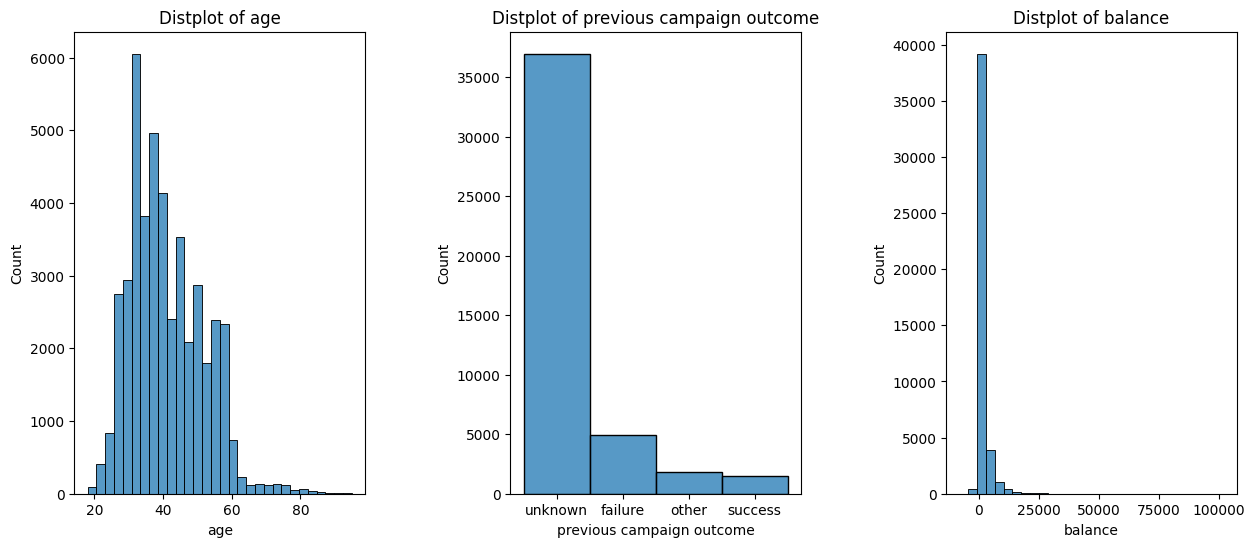

In [937]:
plt.figure(1, figsize=(15, 6))
n = 0
for x in ['age', 'previous campaign outcome', 'balance']:
    n += 1
    plt.subplot(1, 3, n)
    plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
    sns.histplot(data[x], bins = 30)
    plt.title('Distplot of {}'.format(x))
plt.show()

Skewness of balance: 0.6931397093928041


C:\Users\linda\AppData\Local\Temp\ipykernel_12496\213411322.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data['days passed since last contact'], palette='Set2')


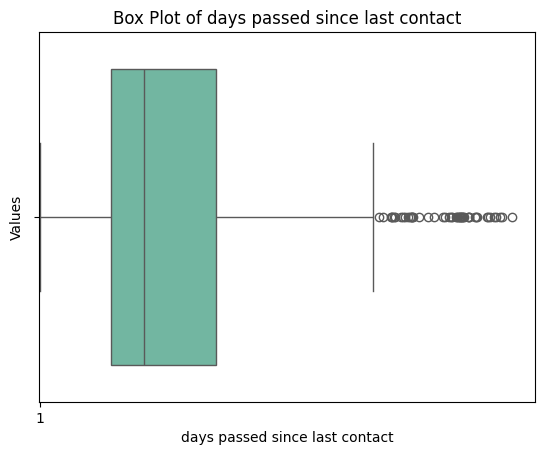

In [938]:
skewness = data['days passed since last contact'].skew()
print(f"Skewness of balance: {skewness}")
plt.boxplot(data['days passed since last contact'])
sns.boxplot(x=data['days passed since last contact'], palette='Set2')
plt.title('Box Plot of days passed since last contact')
plt.ylabel('Values')
plt.show()

0        0.487299
1        0.487299
2        0.487299
3        0.487299
4        0.487299
           ...   
45206    0.717119
45207    0.642027
45208    0.790092
45209    0.761204
45210    0.642027
Name: times contacted this campaign, Length: 45211, dtype: float64
Skewness of balance: 0.23094234176820008


C:\Users\linda\AppData\Local\Temp\ipykernel_12496\814001587.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data['times contacted this campaign'], palette='Set2')


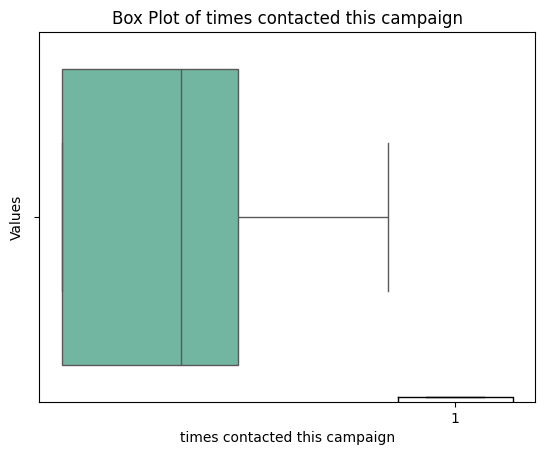

In [939]:
# Box-Cox transformation
data['times contacted this campaign'], fitted_lambda = stats.boxcox(data['times contacted this campaign'] + 1)  # Add 1 to avoid zeros
print(data['times contacted this campaign'])

skewness = data['times contacted this campaign'].skew()
print(f"Skewness of balance: {skewness}")
plt.boxplot(data['times contacted this campaign'])
sns.boxplot(x=data['times contacted this campaign'], palette='Set2')
plt.title('Box Plot of times contacted this campaign')
plt.ylabel('Values')
plt.show()

Skewness of balance: 8.360308326166324


C:\Users\linda\AppData\Local\Temp\ipykernel_12496\480694696.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data['balance'], palette='Set2')


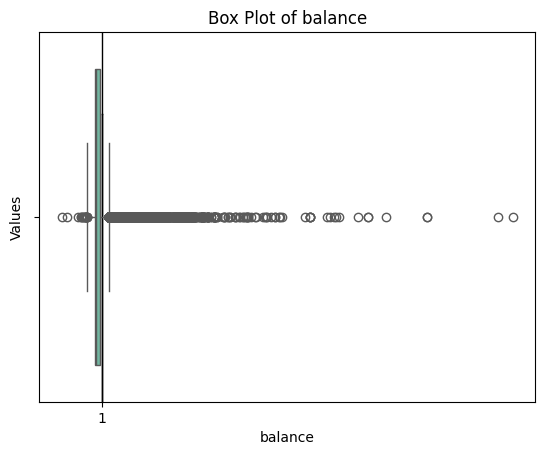

In [940]:
scaler = RobustScaler()
data['balance'] = scaler.fit_transform(data[['balance']])

skewness = data['balance'].skew()
print(f"Skewness of balance: {skewness}")
plt.boxplot(data['balance'])
sns.boxplot(x=data['balance'], palette='Set2')
plt.title('Box Plot of balance')
plt.ylabel('Values')
plt.show()

In [941]:
response_rate = data['outcome'].value_counts(normalize=True) * 100
print("Response Rate:\n", response_rate)


Response Rate:
 outcome
no     88.30152
yes    11.69848
Name: proportion, dtype: float64


In [942]:
data['previous campaign outcome'].replace('unknown', np.nan, inplace=True)
print(data['previous campaign outcome'].value_counts())  # Counts for 'days passed since last contact'
print(data['education'].value_counts())  # Counts for 'days passed since last contact'

previous campaign outcome
failure    4901
other      1840
success    1511
Name: count, dtype: int64
education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: count, dtype: int64


C:\Users\linda\AppData\Local\Temp\ipykernel_12496\4010892649.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['previous campaign outcome'].replace('unknown', np.nan, inplace=True)


In [943]:
features = ['age','job', 'marital', 'education', 'default', 'balance', 'housing', 'loan','times contacted this campaign', 'days passed since last contact', 'previous campaign outcome', 'outcome']
X = data[features]

In [944]:
# Define feature groups
categorical_features = ['job', 'marital', 'default', 'housing', 'loan', 'previous campaign outcome']
ordinal_features = ['education']  # Assuming it has an order (e.g., primary < secondary < tertiary)
numerical_features = ['age', 'balance', 'days passed since last contact', 'times contacted this campaign']

# Separate feature types from the dataset
X_categorical = X[categorical_features]
X_ordinal = X[ordinal_features]
X_numerical = X[numerical_features]
y_categorical = X['outcome']

# Handle Ordinal Encoding for 'education'
education_order = ['unknown', 'primary', 'secondary', 'tertiary']
ordinal_encoder = OrdinalEncoder(categories=[education_order])
X_ordinal['education_encoded'] = ordinal_encoder.fit_transform(X_ordinal[['education']])

# One-Hot Encoding for categorical features
X_categorical_encoded = pd.get_dummies(X_categorical, drop_first=True)

# Combine all features
X_final = pd.concat([
    X_categorical_encoded,        # Add one-hot encoded categorical features
    X_ordinal['education_encoded'],  # Add ordinal-encoded 'education'
    X_numerical# Add numerical features
], axis=1)

# Ensure the final feature set has no missing values

C:\Users\linda\AppData\Local\Temp\ipykernel_12496\3464947795.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_ordinal['education_encoded'] = ordinal_encoder.fit_transform(X_ordinal[['education']])


In [945]:
print(X_final.dtypes)

job_blue-collar                         bool
job_entrepreneur                        bool
job_housemaid                           bool
job_management                          bool
job_retired                             bool
job_self-employed                       bool
job_services                            bool
job_student                             bool
job_technician                          bool
job_unemployed                          bool
job_unknown                             bool
marital_married                         bool
marital_single                          bool
default_yes                             bool
housing_yes                             bool
loan_yes                                bool
previous campaign outcome_other         bool
previous campaign outcome_success       bool
education_encoded                    float64
age                                    int64
balance                              float64
days passed since last contact       float64
times cont

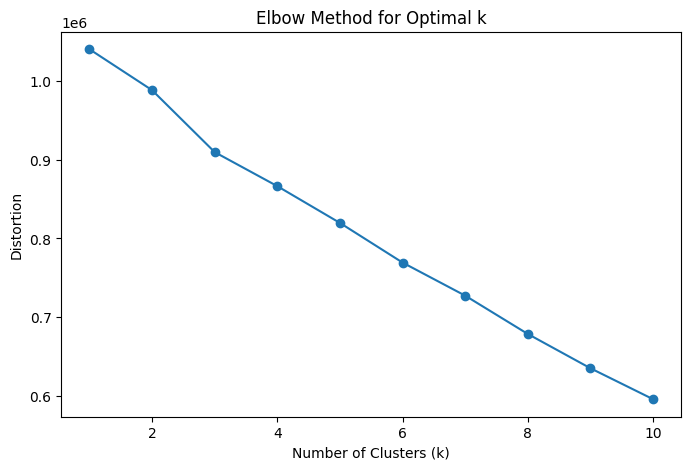

In [946]:
# Handle missing values if any
X_final.fillna(X_final.median(), inplace=True) 

X_final = X_final.apply(pd.to_numeric, errors='coerce')

scaler = StandardScaler()
scaled_features = scaler.fit_transform(X_final)

distortions = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    distortions.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), distortions, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Distortion")
plt.show()



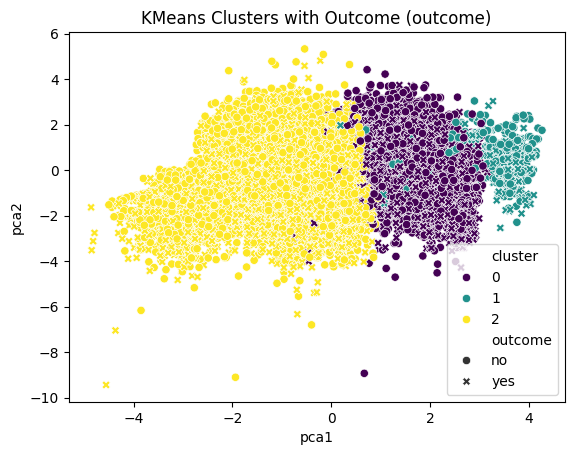

In [947]:
# Fit KMeans with optimal number of clusters
kmeans = KMeans(n_clusters=3, random_state=42)
X_final['cluster'] = kmeans.fit_predict(scaled_features)

# Reduce dimensions to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaled_features)

# Add PCA components to X_final
X_final['pca1'] = X_pca[:, 0]
X_final['pca2'] = X_pca[:, 1]

X_final['outcome'] = X['outcome']

# Scatter plot of clusters
sns.scatterplot(X_final, x='pca1', y='pca2', hue='cluster', palette='viridis', style='outcome')
plt.title('KMeans Clusters with Outcome (outcome)')
plt.show()

In [948]:
# Check how clusters relate to the outcome (outcome)
cluster_analysis = X_final.groupby(['cluster', 'outcome']).size().unstack(fill_value=0)
print(cluster_analysis)

# Calculate the percentage of subscription outcome ('yes'/'no') per cluster
cluster_analysis_percentage = cluster_analysis.div(cluster_analysis.sum(axis=1), axis=0) * 100
print(cluster_analysis_percentage)

print(X_final.dtypes)

outcome     no   yes
cluster             
0        11094  1766
1          669   269
2        28159  3254
outcome         no        yes
cluster                      
0        86.267496  13.732504
1        71.321962  28.678038
2        89.641231  10.358769
job_blue-collar                         bool
job_entrepreneur                        bool
job_housemaid                           bool
job_management                          bool
job_retired                             bool
job_self-employed                       bool
job_services                            bool
job_student                             bool
job_technician                          bool
job_unemployed                          bool
job_unknown                             bool
marital_married                         bool
marital_single                          bool
default_yes                             bool
housing_yes                             bool
loan_yes                                bool
previous campaign outcome

In [957]:
# Encode target variable 'outcome' ('yes' as 1, 'no' as 0)
X_final['outcome_encoded'] = X_final['outcome'].map({'yes': 1, 'no': 0})

# Define the feature matrix A and target vector y
A = X_final.drop(columns=['outcome', 'outcome_encoded', 'cluster', 'pca1', 'pca2'])  # Drop unnecessary columns
y = X_final['outcome_encoded']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(A, y, test_size=0.3, random_state=42)

# Train a Random Forest Classifier
clf = RandomForestClassifier(min_samples_leaf=2, min_samples_split=5, random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')


Accuracy: 0.8925833087584784


              precision    recall  f1-score   support

           0       0.90      0.99      0.94     11966
           1       0.67      0.18      0.28      1598

    accuracy                           0.89     13564
   macro avg       0.78      0.58      0.61     13564
weighted avg       0.87      0.89      0.86     13564

[[11826   140]
 [ 1317   281]]


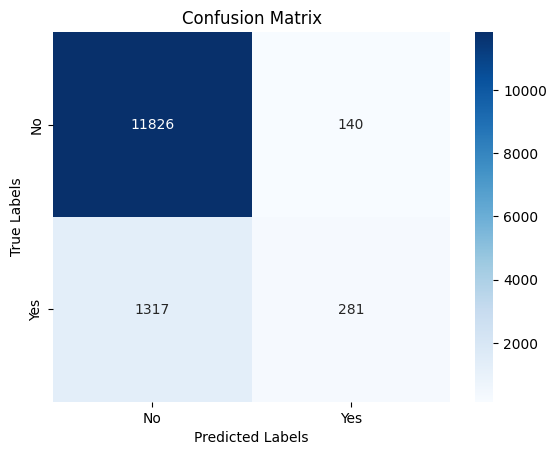

In [958]:
# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()


                              Feature  Importance
20                            balance    0.259376
19                                age    0.215213
21     days passed since last contact    0.135597
17  previous campaign outcome_success    0.125304
22      times contacted this campaign    0.070571
18                  education_encoded    0.034490
14                        housing_yes    0.033959
15                           loan_yes    0.013855
11                    marital_married    0.013291
8                      job_technician    0.012294
12                     marital_single    0.011278
3                      job_management    0.011277
0                     job_blue-collar    0.009447
16    previous campaign outcome_other    0.009082
6                        job_services    0.007417
4                         job_retired    0.007152
7                         job_student    0.006712
9                      job_unemployed    0.005874
5                   job_self-employed    0.005705


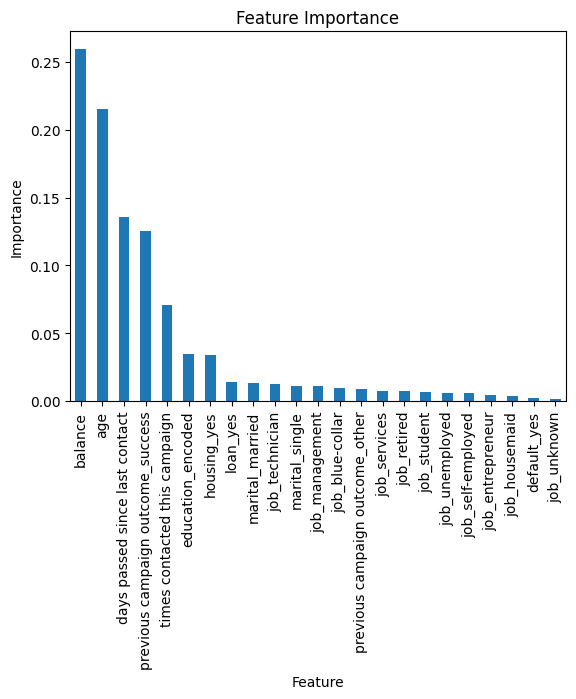

In [959]:
# Get feature importance
feature_importances = clf.feature_importances_

# Create a DataFrame to view feature importances
importance_data = pd.DataFrame({
    'Feature': A.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_data)

# Plot
importance_data.plot(kind='bar', x='Feature', y='Importance', legend=False)
plt.title('Feature Importance')
plt.ylabel('Importance')
plt.show()


In [902]:
random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_grid,
    n_iter=20,  # Number of random combinations to test
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

random_search.fit(X_train, y_train)
print(f"Best Parameters: {random_search.best_params_}")

# Evaluate the best model
best_clf = random_search.best_estimator_
y_pred_best = best_clf.predict(X_test)
print(f'Accuracy with best parameters: {accuracy_score(y_test, y_pred_best)}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 20}
Accuracy with best parameters: 0.8934680035387791


In [903]:
# Perform 10-fold cross-validation
cv_scores = cross_val_score(clf, A, y, cv=5)

# Print average cross-validation score
print(f"Average Cross-Validation Score: {cv_scores.mean()}")

Average Cross-Validation Score: 0.8533757353809321
